In [1]:
from itertools import product, islice
from typing import Dict, List, Any, Tuple, Callable
import os
import pickle
from timeit import default_timer as timer
import math

import numpy as np
import matplotlib.pyplot as plt

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator
from tools.FractalDimension import fractal_dimension
from tools.monte_carlo_integral import monte_carlo_integrate
from tools.dataset_analyse import weighting_xi_in_datasets, weighting_u_pf_y_p_in_datasets, get_datasets_hankel_matrix, Sampler, from_deg_to_rad

In [2]:
# read results from file
results_file_name = '10-26_13_23-results_list.pkl'
with open(os.path.join(os.curdir, 'datasets', results_file_name), 'rb') as f:
    results_list: List[Results] = pickle.load(f)

In [3]:
dataset_name_list: List[str]  = [
    '10-26-12-48-24-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-12-54-32-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-01-13-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-08-53-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '10-26-13-16-41-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
]

In [4]:
len(dataset_name_list)

5

In [5]:
for result in results_list:
    print(result.mark_time_steps)
    # print([traj_slice[0] for traj_slice in result._error_trajectory_slices])
# print(round(5.32/0.01)-1)

[]
[]
[]
[]
[]
[347, 331, 311, 551, 535, 515]
[]
[]
[]
[1259, 1243, 1223]
[]
[]
[]
[]
[]
[947, 931, 911]
[]
[263, 247, 227]
[]
[51, 35, 15]
[]
[]
[]
[]


In [34]:
# parameters for analysis stored in Sampler
sampler = Sampler()
sampler.l_p = 10
sampler.l_f = 85

# results and dataset index to analyse
results_index = range(2, 24, 4)
dataset_list: List[List[List[IODataWith_l]]] = []
for i in range(len(dataset_name_list)):
    with open(os.path.join(os.curdir, 'datasets', dataset_name_list[i]), 'rb') as f:
        single_dataset_list: List[List[IODataWith_l]] = pickle.load(f)
    dataset_list.append(single_dataset_list)

# get output and input size
m = dataset_list[0][0][0]._input_data[0].shape[0]
p = dataset_list[0][0][0]._output_data[0].shape[0]

# # extended state to analyse
# state_index = 159
# results = results_list[results_index[0]]
# t_proposed = (state_index+1) * results.Ts
# u_list, y_list = [], []
# for i in range(state_index-sampler.l_p+1, state_index+1):
#     u_list.append(results._input_applied[i])
#     y_list.append(from_deg_to_rad(results._error_trajectory[i][:p]))
# xi_to_analyse = np.hstack(u_list + y_list)
# # print(xi_to_analyse)

# # extended state with future input to analyse. use the 
# u_future_list = []
# index_proposed = [trajectory_slice[0] for trajectory_slice in results._proposed_input_slices].index(t_proposed)
# list_proposed_u = results._proposed_input_slices[index_proposed][1]
# for i in range(sampler.l_f):
#     u_future_list.append(list_proposed_u[i])
# u_pf_y_p_to_analyse = np.hstack(u_list + u_future_list + y_list)
# # print(u_pf_y_p_to_analyse)

# # index of segment to analyse
# i_seg = results._segment_index_list[state_index]
# print(i_seg)

results_list_to_analyse = [results_list[i] for i in results_index]
# results_list_to_analyse = results_list
dataset_list_to_analyse = dataset_list
print(len(results_list_to_analyse))
print(len(dataset_list_to_analyse))
len(results_list_to_analyse[0]._error_trajectory_slices)

6
5


10

In [36]:
for result in results_list_to_analyse:
    print(len(result._predicted_error_with_slack_slices))
    error_list = np.ndarray(shape = (0,))
    for  prediction_with_slack, real_trajectory in zip(result._predicted_error_with_slack_slices, result._error_trajectory_slices):
        prediction_with_slack = np.hstack(prediction_with_slack[1][0:20])
        real_trajectory = np.hstack(real_trajectory[1][0:20])
        error_list = np.hstack((error_list, prediction_with_slack-real_trajectory))
    error = np.linalg.norm(error_list, ord=np.inf)
    print(error)

10
8.137779875595996
10
11.13501936479437
10
13.307896234072121
10
10.174395873376378
10
9.414288110664504
10
9.623729250127308


In [8]:
from tools.dataset_analyse import normalize_locs_list
from tools.FractalDimension import local_fractal_dimension

lag_fractal = 1
L_fractal = 0
i_seg = 0
locs_list = []
for datasets_for_segments in dataset_list:
    dataset_list_for_segment = datasets_for_segments[i_seg]
    H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list_for_segment, lag=lag_fractal, L=L_fractal)
    locs = np.array(H_uy_noised[m:].T)
    print(locs.shape)
    region_min = np.min(locs, axis=0)
    region_max = np.max(locs, axis=0)
    locs = normalize_locs_list([locs], region_min, region_max)[0]
    locs_list.append(locs)

middle_points, fractal_dimension_list = local_fractal_dimension(locs_list)

(1332, 4)
(1616, 4)
(1892, 4)
(2172, 4)
(2460, 4)


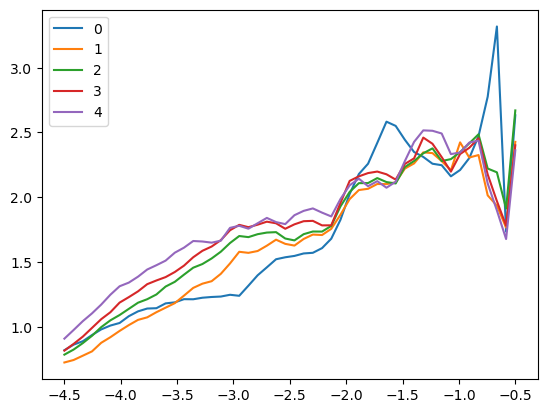

In [12]:
for i in range(len(fractal_dimension_list)):
    fractal_dimension = fractal_dimension_list[i]
    plt.plot(middle_points, fractal_dimension, label=f"{i}")
plt.legend()

(1616, 4)
0.7932395093816671


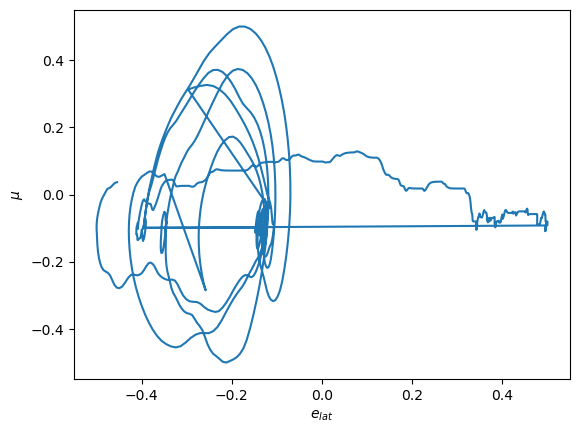

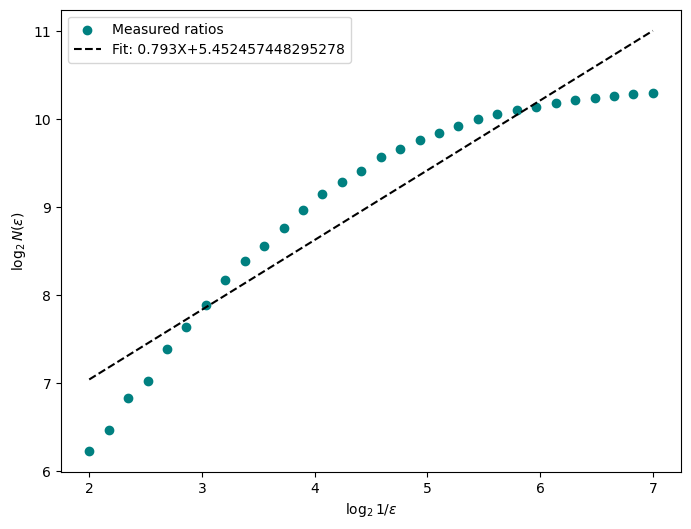

In [44]:
# from tools.dataset_analyse import normalize_locs_list

dataset_list_for_seg = dataset_list_to_analyse[1][i_seg]
H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list_for_seg, lag=lag_fractal, L=L_fractal)
locs = np.array(H_uy_noised[m:].T)
print(locs.shape)
plt.xlabel(r'$e_{lat}$')
plt.ylabel(r'$\mu$')

region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
locs = normalize_locs_list([locs], region_min, region_max)[0]
plt.plot(locs[:,0], locs[:,1])
normalized_regin_min = np.min(locs, axis=0)
normalized_regin_max = np.max(locs, axis=0)

d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=normalized_regin_min, region_max=normalized_regin_max, max_box_size=-2, min_box_size=-7, n_samples=30, n_offsets=20, plot=True)
print(d)

1.2130828841890635


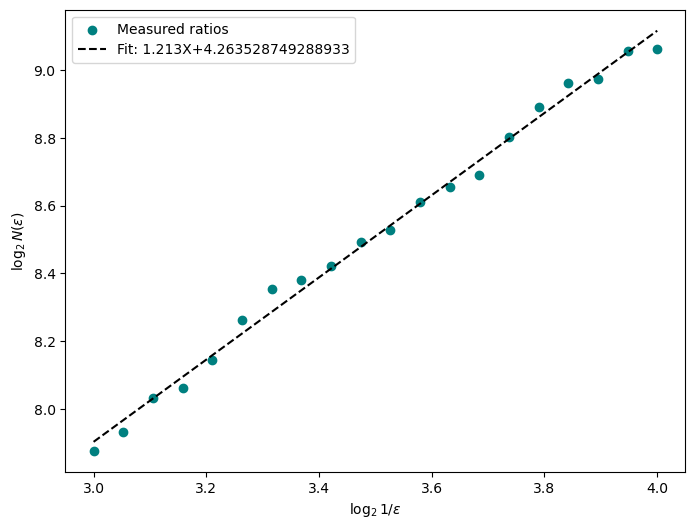

In [47]:
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=normalized_regin_min, region_max=normalized_regin_max, max_box_size=-3.0, min_box_size=-4.0, n_offsets=20, n_samples=20, plot=True)
print(d)

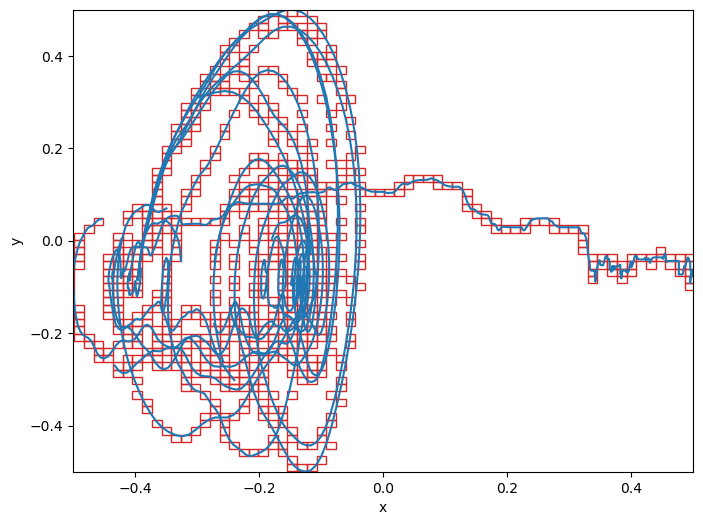

In [42]:
from tools.FractalDimension import plot_squares
from tools.dataset_analyse import get_datasets_hankel_matrix_list


H_uy_noised_list, _ = get_datasets_hankel_matrix_list(io_data_list=dataset_list_for_seg, lag=lag_fractal, L=L_fractal)
locs_list = [np.array(H_uy_noised[m:].T) for H_uy_noised in H_uy_noised_list]
locs_all = np.vstack(locs_list)
region_min = np.min(locs_all, axis=0)
region_max = np.max(locs_all, axis=0)
locs_list = normalize_locs_list(locs_list, region_min, region_max)
locs_all = np.vstack(locs_list)
normalized_regin_min = np.min(locs_all, axis=0)
normalized_regin_max = np.max(locs_all, axis=0)


plot_squares(locs_list=locs_list, scale=-6, region_min=normalized_regin_min, region_max=normalized_regin_max, n_offsets=30)

In [ ]:
# parameters used for analysing dataset

size_xi = len(xi_to_analyse)
size_uy = len(u_pf_y_p_to_analyse)
print(size_xi, size_uy)

W_xi = np.matrix(np.eye(size_xi))
W_uy = np.matrix(np.eye(size_uy))
f = lambda x: 0.01/x

lag = 10
L = 85

weighting_xi_list: List[float] = []
weighting_uy_list: List[float] = []
for dataset_list_for_track in dataset_list:
    dataset_list_for_seg = dataset_list_for_track[i_seg]
    print([data.length for data in dataset_list_for_seg])

    # evalueate the weighting matrix for xi
    weighting_xi = weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=xi_to_analyse)
    weighting_xi_list.append(weighting_xi)
    print(f"The weight of xi: {weighting_xi}")

    # evalueate the weighting matrix for u_pf_y_p
    weighting_uy = weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=u_pf_y_p_to_analyse)
    weighting_uy_list.append(weighting_uy)
    print(f"The weight of u_pf_y_p: {weighting_uy}")

    # try monte carlo integral
    # start = timer()
    values = []
    errors = []
    for n in [5, 100, 10000]:
        integrand = lambda x: weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=x)
        value, error = monte_carlo_integrate(integrand, sampler.xi_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for xi integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for xi integral: {end-start}")

    # start = timer()
    values = []
    errors = []
    for n in [5, 10, 100, 10000]:
        integrand = lambda x: weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=x)
        value, error = monte_carlo_integrate(integrand, sampler.u_pf_y_p_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for u_pf_y_p integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for u_pf_y_p integral: {end-start}")
    print("--------------------------------------------------")


NameError: name 'xi_to_analyse' is not defined